In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pcapng
from pcapng import FileScanner
import os
from IPython.display import display, clear_output
import time

In [2]:
# need to pip install python-pcapng
# check that directory has forward slashes, not back slashes

In [3]:
packet_array = []
# Declares the list that will hold the hexadecimal data for each packet.

###########################################################
path = "C:/Users/brett/Code/Python/OIR Lab/Pause_onskyph0pe_ima0pe__20230426_040905.pcapng"
# Specifies the path to the file to be used in processing.
# Don't forget to change when using a new file.
###########################################################

with open(path, 'rb') as file:
    scanner = FileScanner(file)
    for block in scanner:
        if isinstance(block, pcapng.blocks.EnhancedPacket):
            # Checks, while iterating over each block, if it is of the EnchancedPacket data type. If so,
            # its hexadecimal packet data is stored in 'packet_array'.
            
            packet = block.packet_data
            hex_data = packet.hex()
            packet_array.append(hex_data)

In [4]:
def separated_hex_values(packet):
    '''
    This function reads in a list of hexadecimal packet data, without spaces between each pair of characters,
    and separates each hexadecimal value and assings them to a list so that they can be iterated over within
    a loop for further processing.
    '''
    separated_hexadecimal_array = []
    packet_length = len(packet)
    i = 0
    j = 1
    for character in packet:
        if j < packet_length:
            separated_hexadecimal_array.append(packet[i]+packet[j])
            i += 2
            j += 2    
    return separated_hexadecimal_array
# Reads the raw hexadecimal data string for a packet and encodes it into a list of hexadecimal values.

def hexadecimal_to_decimal(hexadecimal_array):
    '''
    This function reads the hexadecimal value list for a packet and converts each into decimal form.
    '''
    decimal_array = []
    for element in hexadecimal_array:
        decimal_array.append(int(element, 16))
    return decimal_array
# Converts the separated hexadecimal array into a decimal array.

def decimal_converted_packet(packet):
    '''
    This function performs the operations for both the 'separated_hex_values' and 'convert_hexadecimal_to_decimal'
    functions on a packet.
    '''
    return hexadecimal_to_decimal(separated_hex_values(packet))
# Performs the function of the 'separated_hex_values' function and then performs the 'convert_hexadecimal_to_decimal' 
# function on the same data.

def isolate_packet_pixel_data(packet_data):
    '''
    This function removes non-pixel data from the list of integer values. For science images, this means the first
    16 values are removed.
    '''
    converted_packet_data = decimal_converted_packet(packet_data)
    return converted_packet_data[58:]
# Returns a decimal array for the packet data excluding the first 16 elements, which do not correspond to science packet
# pixel data.

def isolate_packet_data(packet_data):
    converted_packet_data = decimal_converted_packet(packet_data)
    return converted_packet_data[42:]

# The Wireshark capture files are 570 bytes in size. The pixel data are stored in the last 528 bytes of the capture.
# Therefore, I am subtracting the first 58 bytes of the capture file because they do not correspond to pixel data.
# This must be done in combination with the subtraction of the first 16 elements of each packet.

In [5]:
# Testing the functions...

testing_packet1 = packet_array[0]
testing_packet2 = packet_array[27001]
testing_packet3 = packet_array[526]
testing_packet4 = packet_array[12654]
# Randomly selected packets used for testing the functions defined above.

#print(isolate_packet_pixel_data(testing_packet1), '\n')
#print(isolate_packet_pixel_data(testing_packet2))

#print(len(isolate_packet_pixel_data(testing_packet1)))

In [6]:
#testing_packet1 = packet_array[16000]
#print(decimal_converted_packet(testing_packet1))
#print(decimal_converted_packet(testing_packet1)[26])

In [7]:
file_packet_integer_data = []

for element in packet_array:
    file_packet_integer_data.append(isolate_packet_pixel_data(element))

In [8]:
def convert_integer_to_binary(integer):
    binary_array = []
    bit_number = 0
    quotient = integer
    
    while bit_number <= 7:
        binary_array.append(quotient%2)
        quotient = int(quotient/2)
        bit_number += 1

    return binary_array

def convert_packet_array_to_8bit_binary(packet):
    packet_binary_array_8bit = []
    for element in isolate_packet_pixel_data(packet):
        packet_binary_array_8bit.append(convert_integer_to_binary(element))
                
    return packet_binary_array_8bit

In [9]:
def concatenate_pixel_data_streams(packet):
    even_array = []
    odd_array = []
    combined_array = []
    
    i = 0
    
    for element in convert_packet_array_to_8bit_binary(packet):
    
        if i%2 == 0:
            even_array.append(element)
        if i%2 == 1:
            odd_array.append(element)

        i += 1
    i = 0
    
    #even_array = even_array[::-1]
    #odd_array = odd_array[::-1]

    for element in even_array:
        combined_array.append(odd_array[i][::-1] + even_array[i][::-1])
        #  ** * * * ** * * Flipping the arrays and concatenating them in accordance with the Quabo packet interface information ******* * ** * ** * *

        i += 1
    
    return combined_array

def convert_16bit_binary_to_integer(number):
    
    i = 15
    integer = 0
    
    for element in number:
        integer += (int(element)*(2**i))
        i -= 1
    
    return integer

def concatenate_streams_and_convert_to_integer(packet):
    
    concatenated_array = []
    for element in concatenate_pixel_data_streams(packet):
        concatenated_array.append(convert_16bit_binary_to_integer(element))
        
    return concatenated_array

In [10]:
test = []
for element in concatenate_pixel_data_streams(testing_packet1):
    test.append(convert_16bit_binary_to_integer(element))

In [11]:
def row_splitter(packet):
    
    image = []
    full_array = []
    counter = 0
    
    for element in concatenate_pixel_data_streams(packet):
        full_array.append(convert_16bit_binary_to_integer(element))
    row_array = []
    
    for element in full_array:
        if counter == 15:
            image.append(row_array)
            row_array.append(element)
            row_array = []
            counter = 0
        else:
            row_array.append(element)
            counter += 1
            
    return image

#creates a 2D array with 16 rows of 16 elements (pixel data to be plotted)

In [12]:
file_packet_intensity_data = []
image_list = []

counter = 0

for packet in packet_array:
    file_packet_intensity_data.append(row_splitter(packet))
    image_list.append('image'+str(counter))
    counter += 1

In [13]:
def get_image_source_ip(packet):
    return str(decimal_converted_packet(packet)[26])+'.'+str(decimal_converted_packet(packet)[27])+'.'+str(decimal_converted_packet(packet)[28])+'.'+str(decimal_converted_packet(packet)[29])

In [14]:
class Image:
    def __init__(self, name, number, source_ip, data):
        self.name = name
        self.number = number
        self.source_ip = source_ip
        self.data = data

In [15]:
object_list = []

counter = 0

for image in packet_array:
    image_object = Image('image'+str(counter), counter, get_image_source_ip(image), file_packet_intensity_data[counter])
    object_list.append(image_object)
    counter += 1

In [16]:
ip_list = []

for element in object_list:
    if element.source_ip not in ip_list:
        ip_list.append(element.source_ip)
        



print(object_list[9].source_ip)
print(ip_list)

192.168.0.15
['192.168.3.248', '192.168.0.4', '192.168.0.12', '192.168.3.249', '192.168.0.13', '192.168.0.6', '192.168.3.250', '192.168.0.14', '192.168.3.251', '192.168.0.15', '192.168.0.5', '192.168.0.7', '192.168.1.102', '30.97.192.168', '208.108.192.168', '208.40.192.168', '208.164.192.168', '208.140.192.168', '224.180.192.168', '208.192.192.168', '208.88.192.168', '208.112.192.168', '208.48.192.168']


In [17]:
initial_list = []

for element in ip_list:
    new_list = [element]
    initial_list.append(new_list)

address_dictionary = {key: [] for key in ip_list}

for element in object_list:
    for key in address_dictionary:
        if element.source_ip == key:
            address_dictionary[key].append(element.name)

In [18]:
print(len(object_list[483].data))

0


In [19]:
#name_list = []
#for element in object_list:
#    name_list.append(test_function_PER_ADDRESS)
    
#print(name_list)

In [20]:
#break
directory = 'S:/'

#index_dictionary = {key: int for key in image_list}
#print(index_dictionary)

#def image_plotter(image):
    
    #if image_name in image_list:
        #index = 
'''
    i = 1
    for element in file_packet_intensity_data[]:
        if len(element) == 16:
            plt.figure()
            plt.imshow(element)
            plt.savefig(os.path.join(directory, 'figure'+str(i)+'.jpg'), format='jpg')
            i += 1
'''

"\n    i = 1\n    for element in file_packet_intensity_data[]:\n        if len(element) == 16:\n            plt.figure()\n            plt.imshow(element)\n            plt.savefig(os.path.join(directory, 'figure'+str(i)+'.jpg'), format='jpg')\n            i += 1\n"

In [21]:
def image_plotter(image):
    if len(image.data) > 0:
        plt.title(str(image.name))
        plt.imshow(image.data)
        plt.show()
    #plt.close()

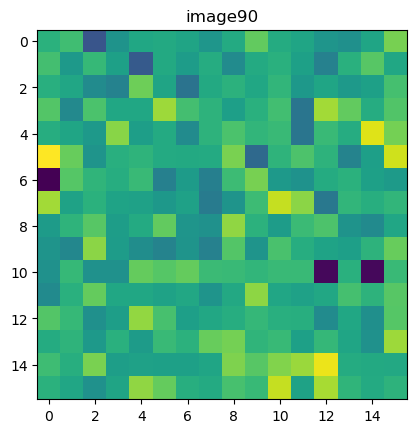

In [22]:
image_plotter(object_list[90])

In [23]:
print(len(object_list[482].data))

0


In [24]:
print(object_list[501].source_ip)

192.168.0.15


In [25]:
if object_list[600].source_ip == '192.168.0.7':
        #print(element.source_ip)
        #image_plotter(object_list[501])
        print('hello kenny')

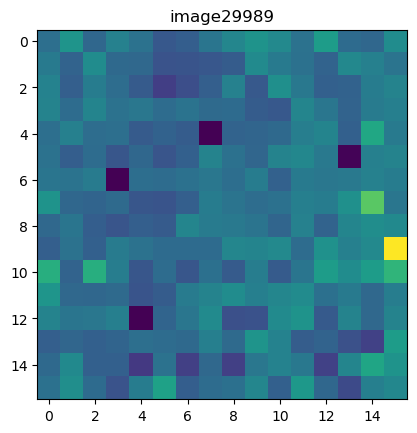

In [26]:
counter = 0
for element in object_list:
    
    if element.source_ip == '192.168.0.12':
        #print(element.source_ip)
        image_plotter(element)

        time.sleep(0.0167)
        clear_output(wait=True)

        counter += 1

In [27]:
break
i=0
for element in object_list:
    if element.source_ip == '192.168.3.248':
        image_plotter(element)
        plt.savefig(os.path.join(directory, 'figure'+str(i)+'.jpg'), format='jpg')
        i+=1

SyntaxError: 'break' outside loop (2757469972.py, line 1)

In [ ]:
frames = []

# Generate each frame and store it in the frames list
for element in object_list:
    image_plotter(element.data)
    plt.savefig('temp.png')  # Save the plot as an image
    frames.append(imageio.imread('temp.png'))
    
imageio.mimsave('animation.mp4', frames, fps=30)